In [ ]:
from google.colab import drive
root = '/content/drive'
drive.mount(root)

Mounted at /content/drive


In [ ]:
!pip install -U bitsandbytes
#!pip install -U evaluate rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
# ✅ Confirm install
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

from datasets import load_from_disk
from huggingface_hub import login
from sentence_transformers import SentenceTransformer
#import evaluate

# MLFlow imports
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.tracking import MlflowClient

import os

import pandas as pd
import re
from pprint import pprint

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations_with_replacement
import numpy as np


from torch.nn.functional import cosine_similarity
from rouge_score import rouge_scorer

# Initialize MLFlow
mlflow.set_tracking_uri("file:///Users/danielcosta/Berkeley/NLP-266/mlruns")
client = MlflowClient()

In [ ]:
recipe_nlg_data_path = f'{root}/MyDrive/NLP-266/Project/RecipeNLG'

### Spearman Correlation Evaluation Helpers

In [ ]:
def get_generated_instruction_list(batch):

  # find all "n."
  # split on "n."
  # Remove number from strings
  # Return list

  instructions = []
  instruction_starts = sorted([match.span() for match in re.finditer(r'\[\d+\]', batch['generated_clean'])])
  for i, span in enumerate(instruction_starts):
    if i == len(instruction_starts) - 1:
      instruction = batch['generated_clean'][span[-1]:]
    else:
      instruction = batch['generated_clean'][span[-1]:instruction_starts[i+1][0]]

    instructions.append(instruction.strip())

  return {"generated_instruction_list": instructions}

def get_reference_instruction_list(batch):
  return {
          "reference_instruction_list": [
              directions.split('", "')
              for directions in batch["directions"]
              ]
      }

def extract_new_tokens(example):
  return {"generated_clean": example['generated'].split("Your response:")[-1].strip()}

def get_generated_instruction_list(batch):
    generated_list = batch["generated_clean"]
    all_instructions = []

    for text in generated_list:
        # Find all "n." (e.g., "1.", "2.", etc.)
        instruction_starts = sorted([match.span() for match in re.finditer(r'\[\d+\]', text)])
        instructions = []

        for i, span in enumerate(instruction_starts):
            if i == len(instruction_starts) - 1:
                instruction = text[span[-1]:]
            else:
                instruction = text[span[-1]:instruction_starts[i+1][0]]
            instructions.append(instruction.strip())

        all_instructions.append(instructions)

    return {"generated_instruction_list": all_instructions}


LIST_DELIM = '", "'

def form_direction_step_text(direction_list_str):
  # parse out parentheses
  direction_str = direction_list_str[1:-1]

  # split string
  str_list = direction_str.split(LIST_DELIM)

  # remove leading and trailing quotes
  str_list[0] = str_list[0][1:]
  str_list[-1] = str_list[-1][:-1]


  # number with consistent formatting [1], [2], ...
  s_list_num = [f'[{i+1}] {s}' for i, s in enumerate(str_list)]
  final_str = '\n'.join(s_list_num)

  return final_str


def get_generated_assignments(example):

    ref = example['reference_instruction_list']
    gen = example['generated_instruction_list']

    if not gen:
        return {"generated_assignments": None}

    ref_embed = model.encode(ref, convert_to_tensor=True).cpu()
    gen_embed = model.encode(gen, convert_to_tensor=True).cpu()

    sims = np.array(
        [
            [cosine_similarity(g, r, dim=0) for r in ref_embed]
            for g in gen_embed
        ]
    ) #g by r matrix

    generated_assignments = np.argmax(sims, axis=1)

    return {"generated_assignments": generated_assignments}

def instruction_similarity(example):

    generated_assignments = example['generated_assignments']

    if generated_assignments is None:
      return {"spearman_correlation": 0.0}
    g_indices = np.arange(len(generated_assignments))

    corr, _ = spearmanr(g_indices, generated_assignments)

    return {"spearman_correlation": corr if not np.isnan(corr) else 0.0}

def get_data_similarity_score(references, generated):
    scores = [
        instruction_similarity(r, g)
        for r, g in zip(references, generated)
    ]

    return np.mean(scores)

def get_data_similarity_score_display(references, generated):
    pairs = zip(references, generated)
    scores = []
    for i, pair in enumerate(pairs):
        score = instruction_similarity(pair[0], pair[1])
        scores.append(score)
    return np.mean(scores)

### Setup Sentence Transformer Model

In [ ]:
model_id = 'multi-qa-MiniLM-L6-cos-v1'

# Load a model (change to a newer one if you like)
model = SentenceTransformer(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Spearman Correlation Functions

In [ ]:
def get_data_similarity_score_dataset(dataset, clean=False):

  dataset = dataset.map(extract_new_tokens, batched=False)

  dataset = dataset.map(get_reference_instruction_list, batched=True, batch_size=32)
  dataset = dataset.map(get_generated_instruction_list, batched=True, batch_size=32)

  dataset = dataset.map(get_generated_assignments, batched=False)

  """
  if clean:
    g_r = [[gen, ref] for gen, ref in zip(gens, refs) if len(gen) > 0]
    print(f"Percent Response: {100 * len(g_r) / len(gens):.2f}%")
    gens = [gr[0] for gr in g_r]
    refs = [gr[1] for gr in g_r]
  """

  dataset = dataset.map(instruction_similarity, batched=False)

  return dataset

### MLFlow Dataset Loading Helpers

In [ ]:
def load_dataset_with_mlflow(dataset_path, dataset_name, experiment_name="recipe_evaluation"):
    """Load dataset and log to MLFlow"""
    # Set or create experiment
    try:
        experiment_id = mlflow.create_experiment(experiment_name)
    except:
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
    mlflow.set_experiment(experiment_name)
    
    # Load dataset
    dataset = load_from_disk(f'file://{dataset_path}')
    
    # Log dataset info to MLFlow
    with mlflow.start_run(run_name=f"load_{dataset_name}") as run:
        mlflow.log_param("dataset_path", dataset_path)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_param("num_examples", len(dataset))
        mlflow.log_param("features", list(dataset.features.keys()))
        
        # Log dataset as artifact
        dataset_df = dataset.to_pandas()
        mlflow.log_table(dataset_df.head(100), artifact_file=f"{dataset_name}_sample.json")
        
    return dataset

### Hyperparameter Tests [TODO]

In [ ]:
# Load layer experiment datasets with MLFlow logging
l1 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_1l', 'qlora_1k_1layer', 'layer_experiments')
l2 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_2l', 'qlora_1k_2layer', 'layer_experiments')
l4 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_4l', 'qlora_1k_4layer', 'layer_experiments')
l8 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_8l', 'qlora_1k_8layer', 'layer_experiments')
l12 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_12l', 'qlora_1k_12layer', 'layer_experiments')
l16 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_16l', 'qlora_1k_16layer', 'layer_experiments')

In [ ]:
layer_tests = [
    ('1', l1),
    ('2', l2),
    ('4', l4),
    ('8', l8),
    ('12', l12),
    ('16', l16)
]

In [ ]:
# Log layer experiment results to MLFlow
mlflow.set_experiment("layer_experiments")

scores = []
for n_layers, df in layer_tests:
    with mlflow.start_run(run_name=f"layer_eval_{n_layers}") as run:
        # Log parameters
        mlflow.log_param("n_layers", n_layers)
        mlflow.log_param("dataset_size", len(df))
        
        # Process dataset
        df = get_data_similarity_score_dataset(df, clean=True)
        df_pandas = df.to_pandas()
        
        # Calculate metrics
        good = df_pandas[df_pandas['spearman_correlation'] != 0]
        bad = df_pandas[df_pandas['spearman_correlation'] == 0]
        score = good['spearman_correlation'].mean()
        
        # Log metrics to MLFlow
        mlflow.log_metric("mean_spearman_correlation", score)
        mlflow.log_metric("good_responses", len(good))
        mlflow.log_metric("bad_responses", len(bad))
        mlflow.log_metric("response_rate", len(good) / len(df_pandas))
        
        # Log detailed results as artifact
        results_df = df_pandas[['spearman_correlation']].describe()
        mlflow.log_table(results_df, artifact_file=f"layer_{n_layers}_stats.json")
        
        scores.append(score)
        
        print(f"Layer {n_layers}: Score={score:.4f}, Good/Total: {len(good)}/{len(df_pandas)}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/tmp/ipython-input-1190351358.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Load training size experiment datasets with MLFlow logging
k1 = l1  # Reuse already loaded 1k dataset
k2 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/ft_generated_2k', 'ft_generated_2k', 'training_size_experiments')
k5 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/ft_generated_5k', 'ft_generated_5k', 'training_size_experiments')
k10 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_10k_test_2e_4l', 'qlora_10k_4layer', 'training_size_experiments')

[np.float64(0.4912878062951702), nan]

In [ ]:
# Log training size experiment results to MLFlow
mlflow.set_experiment("training_size_experiments")

k_scores = []
train_size_tests = [(1, k1), (2, k2), (5, k5), (10, k10)]

for k, df in train_size_tests:
    with mlflow.start_run(run_name=f"training_size_{k}k") as run:
        # Log parameters
        mlflow.log_param("training_size_k", k)
        mlflow.log_param("dataset_size", len(df))
        
        # Process dataset
        df = get_data_similarity_score_dataset(df, clean=True)
        df_pandas = df.to_pandas()

        # Calculate metrics
        good = df_pandas[df_pandas['spearman_correlation'] != 0]
        score = good['spearman_correlation'].mean() if len(good) > 0 else 0.0
        
        # Log metrics to MLFlow
        mlflow.log_metric("mean_spearman_correlation", score)
        mlflow.log_metric("good_responses", len(good))
        mlflow.log_metric("total_responses", len(df_pandas))
        mlflow.log_metric("response_rate", len(good) / len(df_pandas))
        
        # Log detailed results
        if len(good) > 0:
            results_df = df_pandas[['spearman_correlation']].describe()
            mlflow.log_table(results_df, artifact_file=f"training_size_{k}k_stats.json")
        
        k_scores.append(score)
        
        print(f"Training size {k}k: Score={score:.4f}, Good/Total: {len(good)}/{len(df_pandas)}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/tmp/ipython-input-1190351358.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


1 Good/1000: 980


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

2 Good/1000: 104


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

5 Good/1000: 0


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

10 Good/1000: 0


([<matplotlib.axis.XTick at 0x7b9d35324c50>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(12, 0, '12'),
  Text(16, 0, '16')])

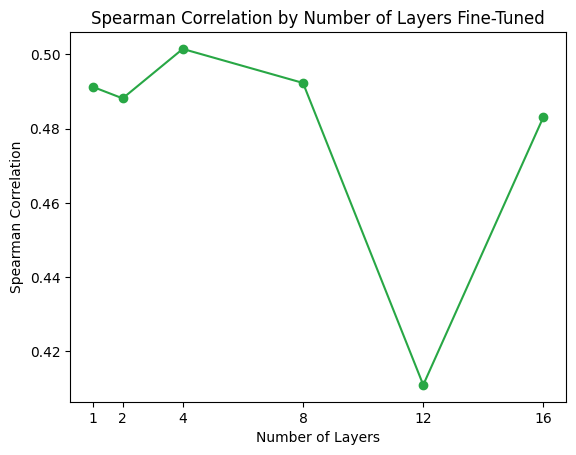

In [ ]:

# Create and log layer experiment visualization
mlflow.set_experiment("layer_experiments")
with mlflow.start_run(run_name="layer_visualization") as run:
    xs = [1, 2, 4, 8, 12, 16]
    plt.figure(figsize=(10, 6))
    plt.plot(xs, scores, marker='o', color='blue')
    plt.title('Spearman Correlation by Number of Layers Fine-Tuned')
    plt.xlabel('Number of Layers')
    plt.ylabel('Spearman Correlation')
    plt.xticks(xs)
    plt.grid(True, alpha=0.3)
    
    # Log the plot to MLFlow
    plt.savefig('/tmp/layer_scores.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact('/tmp/layer_scores.png', 'plots')
    
    # Log summary metrics
    mlflow.log_metric("max_score", max(scores))
    mlflow.log_metric("min_score", min(scores))
    mlflow.log_metric("best_layer_count", xs[scores.index(max(scores))])
    
    plt.show()

### Metric Contradiction Examples

In [ ]:
spearmanr(np.arange(len(ex['generated_assignments']) - 1), [0, 1, 2, 2, 1, 3, 3, 3])

SignificanceResult(statistic=np.float64(0.8647908694379515), pvalue=np.float64(0.0055698626658775285))

In [ ]:
ref = """Preheat the oven to 375°F.

Mix flour, sugar, and eggs in a bowl.

Pour the batter into a greased pan.

Bake for 25 minutes."""

gen = """Set your oven to 375 degrees Fahrenheit.

Combine eggs, sweetener, and flour inside mixer.

Transfer mixture to buttered baking dish.

Cook twenty-five minutes in the oven."""

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
scores = scorer.score(ref,
                      gen)
scores

{'rouge1': Score(precision=0.37037037037037035, recall=0.4, fmeasure=0.3846153846153846),
 'rougeL': Score(precision=0.2222222222222222, recall=0.24, fmeasure=0.23076923076923075)}

## Non-CoT [TODO]

In [ ]:
# Load Non-CoT datasets with MLFlow logging

# Non-Fine-Tuned Non-Retrieval
nft_nr_0 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_generated', 'nft_nr_0_baseline', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_nr_1 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_one_shot_generated', 'nft_nr_1_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_nr_2 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_two_shot_generated', 'nft_nr_2_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_nr_3 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_three_shot_generated', 'nft_nr_3_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

# Non-Fine-Tuned Retrieval
nft_r_1 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_one_shot_retrieval_generated', 'nft_r_1_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_r_2 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_two_shot_retrieval_generated', 'nft_r_2_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_r_3 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_three_shot_retrieval_generated', 'nft_r_3_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

# Fine-Tuned Non-Retrieval
ft_nr_0 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_4l', 'ft_nr_0_baseline', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_nr_1 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/ft_one_shot', 'ft_nr_1_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_nr_2 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/ft_two_shot', 'ft_nr_2_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_nr_3 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/ft_three_shot', 'ft_nr_3_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

# Fine-Tuned Retrieval
ft_r_1 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/ft_one_shot_ret', 'ft_r_1_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_r_2 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/ft_two_shot_ret', 'ft_r_2_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_r_3 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/ft_three_shot_ret', 'ft_r_3_shot', 'non_cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### CoT [TODO]

In [ ]:
# Load CoT datasets with MLFlow logging
cot_nft_7 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/oob_cot_generated', 'cot_nft_7b', 'cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
cot_ft_7 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/7b_instruction_model_from_teacher_generated_instructions', 'cot_ft_7b', 'cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

cot_nft_13 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/13b_cot_non_ft_instruction_generation', 'cot_nft_13b', 'cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
cot_ft_13 = load_dataset_with_mlflow(f'{recipe_nlg_data_path}/Generated_Data/13b_instruction_model_from_teacher_generated_instructions', 'cot_ft_13b', 'cot_experiments').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

In [ ]:
cot_model_dict = {
    'nft': {
        'retrieval':
            ['1', '2', '3']
        ,
        'non-retrieval':
            ['1', '2', '3']
    }
}

In [ ]:
for ft, val1 in cot_model_dict.items():
  for ret, val2 in val1.items():
    for shots in val2:
      file_ext = f'{recipe_nlg_data_path}/Generated_Data/' \
                 f'cot_{ft}_shots_{shots}_retrieval_{"True" if ret == "retrieval" else "False"}'
      if os.path.exists(file_ext):
        n = load_from_disk(file_ext).map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])}).map(
        extract_new_tokens, batched=False)
        n = n.map(lambda x: {'title_ingredients': form_example_prompt(x)})
        n = n.map(lambda x: {'comparison_prompt': form_comparison_prompt(x['title_ingredients'], x['directions_formatted'], x['generated_clean'])})
        n = n.map(lambda x: {'reference_free_prompt': form_reference_free_prompt(x['title_ingredients'], x['generated_clean'])})
        n = n.map(lambda x: generate_evaluation_batch(
      x, prompt_col='comparison_prompt', model=eval_model, tokenizer=tokenizer),
            batched=True,
            batch_size=16)
        n.save_to_disk(f'file://{file_ext}_eval')


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chinatown Sling
  Ingredients: ["16 ounces pineapple juice", "10 ounces gin", "4 ounces tr

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Pasta with Arugula and Caramelized Onions
  Ingredients: ["1/2 lb. hot Italian sausage, ca

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Vegetable Pasta Sauce (Lactose Free)
  Ingredients: ["1 packages Melissas Extra Firm Tofu"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Fluffy Double-Raspberry Pie
  Ingredients: ["4 pkg. JELL-O Vanilla Flavor Sugar Free Reduc

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cinnamon Grapefruit Sorbet Recipe
  Ingredients: ["2 1/2 Cups Ruby Red Grapefruit Juice", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Lumpia (Filipino Egg Rolls) 
  Ingredients: ["2 tbsp vegetable oil", "1 lb lean ground por

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: topsy turvy sangria
  Ingredients: ["1 bottle merlot", "1 cup sugar", "1 cup orange liqueu

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Three-Cheese Bacon and Kale Dip
  Ingredients: ["4 cups tightly packed chopped stemmed kal

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Savory Squash & Bean Side Dish
  Ingredients: ["6 slices OSCAR MAYER Bacon, chopped Rite A

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Aromatic Fish Soup Recipe
  Ingredients: ["1/2 tsp chilli flakes", "1 tsp cumin", "2 tsp p

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cheesy Sweet Potato Balls
  Ingredients: ["1/2 cup mashed cooked sweet potato", "1 cup coo

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Buttermilk Prairie Waffles
  Ingredients: ["2 cups sifted flour", "1 teaspoon baking powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Shrimp And Pasta Casserole 
  Ingredients: ["1 lb. elbow macaroni", "6 strips bacon, diced

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Fish With Shrimp
  Ingredients: ["3 tablespoons butter", "2 tablespoons all-purpose 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Peaches 'n Creme Pie
  Ingredients: ["48 Nilla Vanilla Wafers, finely crushed (about 1-1/2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Southwest Cornbread Stuffing
  Ingredients: ["2 cups chopped onions King Sooper's 1 lb For

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: The Parasol
  Ingredients: ["1/2 ounce fresh lemon juice", "1/2 ounce fresh lime juice", "

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Savory Beef Roast
  Ingredients: ["1 (4-pound) lean boneless rump roast", "Cooking spray",

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Italian Barbecue Chicken Recipe
  Ingredients: ["4 x chicken breasts", "2 tsp Italia

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sombrero Pasta Salad
  Ingredients: ["1 package (16 ounces) spiral pasta", "1 pound ground

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Eggplant Pizzas
  Ingredients: ["1 cup all-purpose flour", "4 large eggs, beaten", "2-1/2 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cilantro Pesto
  Ingredients: ["1/2 cups (heaping) Blanched, Slivered Almonds", "1 clove F

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Pretzel Pecan Coated Chicken Tenders
  Ingredients: ["2 pounds chicken tenders", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Homemade Cajun Tasso
  Ingredients: ["2 lb thinly sliced scrap pork pieces, trimmed of exc

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Corn-Crusted Catfish
  Ingredients: ["10 ounces catfish fillet", "1/2 cup buttermilk", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Buttermilk Prairie Waffles
  Ingredients: ["2 cups sifted flour", "1 teaspoon baking powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Southwest Cornbread Stuffing
  Ingredients: ["2 cups chopped onions King Sooper's 1 lb For

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Red Chile Sauce
  Ingredients: ["2 tablespoons lard", "2 tablespoons flour, all-purpose", 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cilantro Pesto
  Ingredients: ["1/2 cups (heaping) Blanched, Slivered Almonds", "1 clove F

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Wild Orchid Martini
  Ingredients: ["1 ounce vanilla vodka", "1/2 ounce vodka", "1/2 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mary Mac's Buttermilk Biscuits Recipe
  Ingredients: ["2 c. plus 2 tbsp. all purpose flour

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Quick Chicken with Garlic, Tarragon, and Red Wine
  Ingredients: ["2 tablespoons olive oil

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Classic Sandwich Bread for the Bread Machine
  Ingredients: ["9 oz. milk warmed", "4 tbsp.

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Wedge Salad with Raspberry-Chocolate Vinaigrette
  Ingredients: ["4 slices sourdough bread

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: The “Original” Margarita
  Ingredients: ["FOR RIMMING THE GLASS:", "1 whole Lime, Cut Into

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mom's Apple Cobbler with Buttermilk Biscuit Topping Recipe
  Ingredients: ["4 tablespoons 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Golden Sponge Cake with Creamy Filling
  Ingredients: ["1 box yellow cake mix", "5 tablesp

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Whoopie Cookies
  Ingredients: ["1 package devil's food cake mix (regular size)", "1/4 cup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Wild Orchid Martini
  Ingredients: ["1 ounce vanilla vodka", "1/2 ounce vodka", "1/2 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chocolate, Nut And Cornflake Bars
  Ingredients: ["1/2 cup butter, coarsely chopped", "1/2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Buttermilk Prairie Waffles
  Ingredients: ["2 cups sifted flour", "1 teaspoon baking powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Red Chile Sauce
  Ingredients: ["2 tablespoons lard", "2 tablespoons flour, all-purpose", 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
cot_model_dict = {
    "Non-Fine-Tuned": {
        "7b": cot_nft_7,
        "13b": cot_nft_13
    },
    "Fine-Tuned": {
        "7b": cot_ft_7,
        "13b": cot_ft_13
    }
}

In [ ]:
model_dict = {
    "Non-Fine-Tuned": {
        "Non-Retrieval": {
            "0": nft_nr_0,
            "1": nft_nr_1,
            "2": nft_nr_2,
            "3": nft_nr_3
        },
        "Retrieval": {
            "1": nft_r_1,
            "2": nft_r_2,
            "3": nft_r_3
        }
    },
    "Fine-Tuned": {
        "Non-Retrieval": {
            "0": ft_nr_0,
            "1": ft_nr_1,
            "2": ft_nr_2,
            "3": ft_nr_3
        },
        "Retrieval": {
            "1": ft_r_1,
            "2": ft_r_2,
            "3": ft_r_3
        }
    }
}

In [ ]:
generated_col = 'generated'
reference_col = 'directions_formatted'

### LLM-as-a-Judge Prompting

In [ ]:
# could compare to reference quality or just evaluate on its own

def form_comparison_prompt(original_recipe_prompt, reference, generated):
  comparison_prompt = f"""<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  {original_recipe_prompt}

  ---

  **Reference Instructions:**
  {reference}

  ---

  **Model's' Instructions:**
  {generated}

  ---

  **Your Evaluation:**
[1] Coherence Rating for Reference (1–10):
[2] Coherence Rating for Model (1–10):
[3] Which is better and why (2–5 sentences):

Prepend your answer to the items in these last 3 lines with [1], [2], and [3] respectively.<|im_end|>
<|im_start|>assistant
  """.strip()

  return comparison_prompt

def form_reference_free_prompt(original_recipe_prompt, generated):
  reference_free_prompt = f"""<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 10 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  {original_recipe_prompt}

  ---

  **Model's' Instructions:**
  {generated}

  ---

  **Your Evaluation:**
[1] Coherence Rating (1–10):
[2] Explanation (2–5 sentences):

Prepend your answer to the items in these last 2 lines with [1] and [2] respectively.<|im_end|>
<|im_start|>assistant
  """.strip()

  return reference_free_prompt

def form_example_prompt(example):
  return f'''
  Title: {example['title']}
  Ingredients: {example['ingredients']}
  '''.strip()



PROMPT_HPS = {
    'do_sample': False,                # Disable sampling for determinism
    'temperature': 0.0,                # Eliminate randomness
    'top_p': 1.0,                      # Not used if do_sample=False, but safe
    'max_new_tokens': 256,            # Should be enough for rating + explanation
    'stop_sequences': None,           # Optional: use if you want clean terminations
    'repetition_penalty': 1.0,        # No need for penalty in judgment tasks
    'use_cache': True                 # Leave as is for performance
}

def generate_evaluation_batch(batch, prompt_col=None, model=None, tokenizer=None):

    print(batch[prompt_col][0])

    inputs = tokenizer(
        batch[prompt_col],
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)

    hps = PROMPT_HPS.copy()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **hps,
            pad_token_id=tokenizer.pad_token_id,
            max_length=model.config.max_position_embeddings
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return {f'eval_response_{prompt_col}': decoded}

### Setup Judge Model

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True
)

In [ ]:
### Load Qwen 32B model

model_id = "Qwen/Qwen2.5-Coder-32B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

eval_model = AutoModelForCausalLM.from_pretrained(
  model_id,
  return_dict=True,
  torch_dtype=torch.float16,
  device_map="auto",
  quantization_config=quantization_config
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

### CoT LLM Judge Evaluation Consistency

In [ ]:
dfs = []
for key1, val1 in cot_model_dict.items():
  for key2, df in val1.items():
    file_ext = f'{recipe_nlg_data_path}/Generated_Data/Evaluations/CoT_consistency_{key1}_{key2}'
    dfs.append((df, file_ext))
    print(file_ext)

def llm_judge_trial(df, file_ext):
  df = df.shuffle().select(range(32))
  df = df.map(lambda x: {'title_ingredients': form_example_prompt(x)})
  df = df.map(lambda x: {'comparison_prompt': form_comparison_prompt(x['title_ingredients'], x['directions_formatted'], x['generated'])})
  df = df.map(lambda x: {'reference_free_prompt': form_reference_free_prompt(x['title_ingredients'], x['directions_formatted'])}) # changed 'generated' to 'directions'

  df = df.map(lambda x: generate_evaluation_batch(
  x, prompt_col='reference_free_prompt', model=eval_model, tokenizer=tokenizer),
      batched=True,
      batch_size=16)

  df = df.map(parse_reference_free_evaluation)
  try:
    print(n.to_pandas()['model_rating'].mean())
  except:
    print("Error loading pandas")
    continue
  df.save_to_disk(f'file://{file_ext}')

for i in range(10):
  df, file_ext = dfs[i]
  llm_judge_trial(df, file_ext)


### Non-CoT LLM Eval [TODO]

In [ ]:
# Log Non-CoT LLM evaluation results to MLFlow
mlflow.set_experiment("llm_judge_evaluation")

for key1, val1 in model_dict.items():
    for key2, val2 in val1.items():
        for key3, n in val2.items():
            run_name = f"{key1}_{key2}_{key3}"
            
            with mlflow.start_run(run_name=run_name) as run:
                # Log parameters
                mlflow.log_param("fine_tuned", key1)
                mlflow.log_param("retrieval_type", key2)
                mlflow.log_param("shots", key3)
                mlflow.log_param("dataset_size", len(n))
                
                # Process dataset
                n = n.map(lambda x: {'title_ingredients': form_example_prompt(x)})
                n = n.map(lambda x: {'comparison_prompt': form_comparison_prompt(x['title_ingredients'], x['directions_formatted'], x['generated'])})
                n = n.map(lambda x: {'reference_free_prompt': form_reference_free_prompt(x['title_ingredients'], x['generated'])})
                
                # Generate evaluations
                n = n.map(lambda x: generate_evaluation_batch(
                    x, prompt_col='comparison_prompt', model=eval_model, tokenizer=tokenizer),
                    batched=True,
                    batch_size=16)
                n = n.map(lambda x: generate_evaluation_batch(
                    x, prompt_col='reference_free_prompt', model=eval_model, tokenizer=tokenizer),
                    batched=True,
                    batch_size=16)
                
                # Parse results and log metrics
                n_parsed = n.map(parse_comparison_evaluation).map(parse_reference_free_evaluation)
                results_df = n_parsed.to_pandas()
                
                # Log metrics to MLFlow
                mlflow.log_metric("mean_reference_rating", results_df['reference_rating'].mean())
                mlflow.log_metric("mean_model_rating", results_df['model_rating'].mean())
                mlflow.log_metric("reference_std", results_df['reference_rating'].std())
                mlflow.log_metric("model_std", results_df['model_rating'].std())
                
                # Log detailed results as artifact
                mlflow.log_table(results_df[['reference_rating', 'model_rating']], 
                               artifact_file=f"{run_name}_ratings.json")
                
                print(f"Completed {run_name}: Ref={results_df['reference_rating'].mean():.3f}, Model={results_df['model_rating'].mean():.3f}")



### Results [TODO] (clean magic strings)

In [ ]:
comparison_split = "Prepend your answer to the items in these last 3 lines with [1], [2], and [3] respectively."
reference_free_split = "Prepend your answer to the items in these last 2 lines with [1] and [2] respectively."

def parse_comparison_evaluation(example):

  new_tokens = example['eval_response_comparison_prompt'].split(comparison_split)[-1]
  reference_rating = new_tokens.split("Coherence Rating for Reference (1–10): ")[1].split("\n")[0]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Which is better and why (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"reference_rating": int(reference_rating), "model_rating": int(model_rating), "explanation": explanation}


def parse_reference_free_evaluation(example):

  new_tokens = example['eval_response_reference_free_prompt'].split(reference_free_split)[-1]
  model_rating = new_tokens.split("Coherence Rating (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Coherence Rating (1–10):")[1]
  except:
    explanation = "Not Found"

  return {"model_rating": int(model_rating), "explanation": explanation}

### CoT + Few-Shot Check

In [ ]:
for ft, val1 in cot_model_dict_better.items():
  for ret, val2 in val1.items():
    for shots in val2:
      file_ext = f'{recipe_nlg_data_path}/Generated_Data/' \
                 f'cot_{ft}_shots_{shots}_retrieval_{"True" if ret == "retrieval" else "False"}_eval'

      data = (
          load_from_disk(file_ext)
          .map(parse_comparison_evaluation)
          .to_pandas()
      )
      print(f"Results for {file_ext}")
      print(f"Reference: {data['reference_rating'].mean()}")
      print(f"Model: {data['model_rating'].mean()}")

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_1_retrieval_True_eval
Reference: 7.84
Model: 6.64


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_2_retrieval_True_eval
Reference: 7.92
Model: 6.15


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_3_retrieval_True_eval
Reference: 7.85
Model: 6.24


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_1_retrieval_False_eval
Reference: 7.78
Model: 6.56


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_2_retrieval_False_eval
Reference: 7.87
Model: 6.34


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_3_retrieval_False_eval
Reference: 7.85
Model: 6.34


In [ ]:
def parse_comparison_evaluation(example):

  new_tokens = example['eval_response_comparison_prompt'].split(comparison_split)[-1]
  reference_rating = new_tokens.split("Coherence Rating for Reference (1–10): ")[1].split("\n")[0]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Which is better and why (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"reference_rating": int(reference_rating), "model_rating": int(model_rating), "explanation": explanation}


def parse_reference_free_evaluation(example):

  new_tokens = example['eval_response_reference_free_prompt'].split(reference_free_split)[-1]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Coherence Rating (1–10):")[1]
  except:
    explanation = "Not Found"

  return {"model_rating": int(model_rating), "explanation": explanation}

# Retrieve and display results from MLFlow
def display_mlflow_results(experiment_name):
    """Display results from MLFlow experiment"""
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"Experiment {experiment_name} not found")
        return
    
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    if runs.empty:
        print(f"No runs found for experiment {experiment_name}")
        return
    
    print(f"\n=== Results for {experiment_name} ===")
    for _, run in runs.iterrows():
        run_name = run.get('tags.mlflow.runName', 'Unknown')
        ref_rating = run.get('metrics.mean_reference_rating', 'N/A')
        model_rating = run.get('metrics.mean_model_rating', 'N/A')
        
        print(f"{run_name}: Reference={ref_rating:.3f}, Model={model_rating:.3f}")

# Display results from all experiments
experiments_to_display = [
    "layer_experiments",
    "training_size_experiments", 
    "llm_judge_evaluation",
    "cot_experiments"
]

for exp_name in experiments_to_display:
    display_mlflow_results(exp_name)

Results for Non-Fine-Tuned_Non-Retrieval_0


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reference: 7.707
Model: 7.414
Results for Non-Fine-Tuned_Non-Retrieval_1


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reference: 8.087
Model: 7.032
Results for Non-Fine-Tuned_Non-Retrieval_2


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reference: 7.982
Model: 7.404


## [TODO]

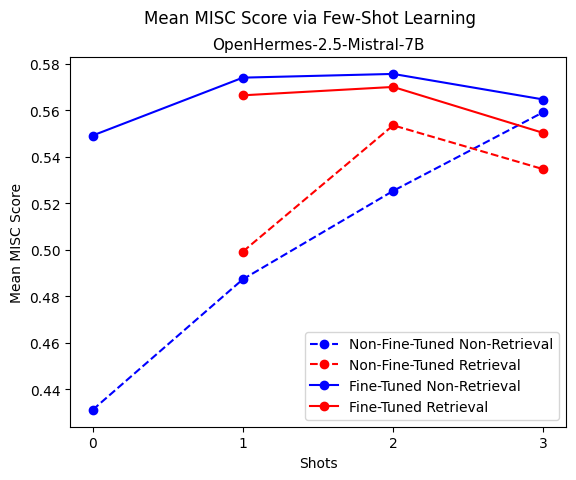

<Figure size 1000x700 with 0 Axes>

In [ ]:
# Create comprehensive visualizations from MLFlow data
def create_mlflow_visualizations():
    """Create visualizations from MLFlow experiment data"""
    
    # Get layer experiments data
    layer_exp = mlflow.get_experiment_by_name("layer_experiments")
    if layer_exp:
        layer_runs = mlflow.search_runs(experiment_ids=[layer_exp.experiment_id])
        if not layer_runs.empty:
            # Create layer performance plot
            plt.figure(figsize=(12, 8))
            
            # Sort by layer count for proper plotting
            layer_data = []
            for _, run in layer_runs.iterrows():
                if 'metrics.mean_spearman_correlation' in run and 'params.n_layers' in run:
                    layer_data.append((
                        int(run['params.n_layers']), 
                        run['metrics.mean_spearman_correlation']
                    ))
            
            if layer_data:
                layer_data.sort(key=lambda x: x[0])
                layers, scores = zip(*layer_data)
                
                plt.subplot(2, 2, 1)
                plt.plot(layers, scores, marker='o', color='blue', linewidth=2)
                plt.title('Spearman Correlation by Number of Layers')
                plt.xlabel('Number of Layers')
                plt.ylabel('Spearman Correlation')
                plt.grid(True, alpha=0.3)
    
    # Get training size experiments data
    train_exp = mlflow.get_experiment_by_name("training_size_experiments")
    if train_exp:
        train_runs = mlflow.search_runs(experiment_ids=[train_exp.experiment_id])
        if not train_runs.empty:
            train_data = []
            for _, run in train_runs.iterrows():
                if 'metrics.mean_spearman_correlation' in run and 'params.training_size_k' in run:
                    train_data.append((
                        int(run['params.training_size_k']), 
                        run['metrics.mean_spearman_correlation']
                    ))
            
            if train_data:
                train_data.sort(key=lambda x: x[0])
                sizes, scores = zip(*train_data)
                
                plt.subplot(2, 2, 2)
                plt.plot(sizes, scores, marker='s', color='green', linewidth=2)
                plt.title('Spearman Correlation by Training Size')
                plt.xlabel('Training Size (k)')
                plt.ylabel('Spearman Correlation')
                plt.grid(True, alpha=0.3)
    
    # Get LLM judge evaluation data
    judge_exp = mlflow.get_experiment_by_name("llm_judge_evaluation")
    if judge_exp:
        judge_runs = mlflow.search_runs(experiment_ids=[judge_exp.experiment_id])
        if not judge_runs.empty:
            # Create comparison of reference vs model ratings
            ref_ratings = []
            model_ratings = []
            labels = []
            
            for _, run in judge_runs.iterrows():
                if 'metrics.mean_reference_rating' in run and 'metrics.mean_model_rating' in run:
                    ref_ratings.append(run['metrics.mean_reference_rating'])
                    model_ratings.append(run['metrics.mean_model_rating'])
                    labels.append(run.get('tags.mlflow.runName', 'Unknown'))
            
            if ref_ratings and model_ratings:
                plt.subplot(2, 2, 3)
                x = range(len(ref_ratings))
                width = 0.35
                plt.bar([i - width/2 for i in x], ref_ratings, width, label='Reference', alpha=0.8)
                plt.bar([i + width/2 for i in x], model_ratings, width, label='Model', alpha=0.8)
                plt.title('LLM Judge Ratings Comparison')
                plt.xlabel('Experiment')
                plt.ylabel('Rating')
                plt.xticks(x, [l[:15] + '...' if len(l) > 15 else l for l in labels], rotation=45)
                plt.legend()
                plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot to MLFlow
    mlflow.set_experiment("visualization_summary")
    with mlflow.start_run(run_name="comprehensive_plots") as run:
        plt.savefig('/tmp/comprehensive_results.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('/tmp/comprehensive_results.png', 'plots')
        
        # Log summary statistics
        if 'layer_data' in locals() and layer_data:
            mlflow.log_metric("best_layer_performance", max(score for _, score in layer_data))
        if 'train_data' in locals() and train_data:
            mlflow.log_metric("best_training_size_performance", max(score for _, score in train_data))
    
    plt.show()

# Create the visualizations
create_mlflow_visualizations()